# Import packages

In [ ]:
!pip install gensim
!pip install wordcloud
!pip install tweet-preprocessor
!pip install emoji
!pip install contractions


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Set preferred endcoding to UTF-8
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
import preprocessor as p
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import re
from gensim.parsing.preprocessing import (
    strip_tags, strip_numeric, strip_punctuation,
    strip_multiple_whitespaces, remove_stopwords, strip_short
)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to C:\Users\Khanh
[nltk_data]     Nguyen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import data

In [ ]:
train_df = pd.read_csv("data/training_data.csv")
train_df.head()

,content,language,retweet_count,reply_count,like_count,quote_count,impression_count,engagement_rate
0,@mikapleskinen @pizzahut Hi Mika!\n\nMy apolog...,en,0.0,0.0,0.0,0.0,31.0,0.000000
1,@Samikohanse @Samikohanse Moikka Sami! Ikävä k...,fi,0.0,1.0,1.0,0.0,15.0,0.133333
2,@Saralye @Saralye Hello there! Thanks for cont...,en,0.0,0.0,0.0,0.0,10.0,0.000000
3,@markuslindqv @markuslindqv Moi Markus! Kiitos...,fi,0.0,0.0,0.0,0.0,21.0,0.000000
4,@fldu_ Hi Florian! \nHuge apologies that your ...,en,0.0,0.0,0.0,0.0,25.0,0.000000


# First overview of the data

In [ ]:
# Check for null values in the dataset
train_df.isnull().sum()

content             0
language            0
retweet_count       0
reply_count         0
like_count          0
quote_count         0
impression_count    0
engagement_rate     0
dtype: int64

Check language distribution

In [ ]:
def count_lang(data, threshold=0.1):
  # Determine the counts of each language in the column:
  language_counts = data["language"].value_counts()
  # Create a mask to filter the languages with proportion more than threshold:
  mask = language_counts > threshold * len(data)
  # Get the languages that meet the mask condition:
  popular_languages = language_counts.index[mask]
  # Create a new column language_category where the popular languages will be labeled and others will be labeled as 'Other':
  data['language_category'] = data['language'].apply(lambda x: x if x in popular_languages else 'Other')

  # Get the value counts and unique labels
  value_counts = data["language_category"].value_counts()
  labels = value_counts.index.tolist()

  # Plot the pie chart
  plt.pie(value_counts, labels=labels, autopct='%1.1f%%')
  plt.show()

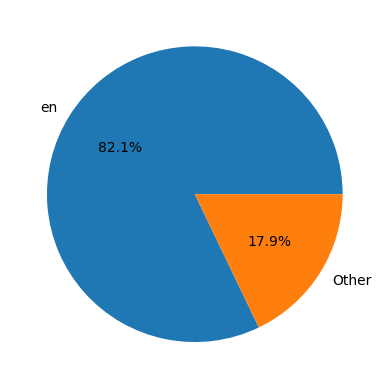

In [ ]:
count_lang(data=train_df)

# Preprocess data
Before preprocessing text, it is significant to detect and remove any anomalies and outliers to better fit the purpose of this project and to guarantee the future quality of the machine learning models.

## Remove outliers

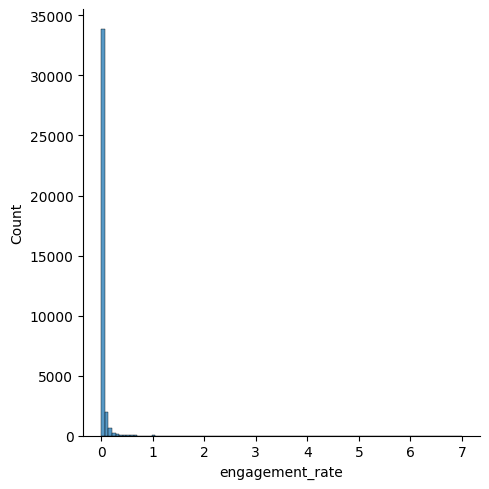

In [ ]:
# Check engagement rate distribution
sns.displot(train_df['engagement_rate'], kde=False, bins=100)

As we could see, the distribution of engagement rates heavily skews to the left. Therefore, we will proceed to remove the outliers to guarantee the future quality of the future machine learning models.

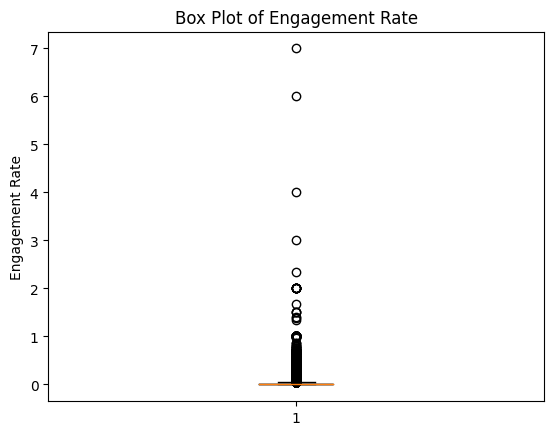

In [ ]:
plt.boxplot(train_df['engagement_rate'])
plt.ylabel('Engagement Rate')
plt.title('Box Plot of Engagement Rate')
plt.show()

In [ ]:
# Define the dataset
engagement_rates = train_df['engagement_rate'].values

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = np.percentile(engagement_rates, 25)
Q3 = np.percentile(engagement_rates, 75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Set a multiplier to define the outlier threshold
threshold_multiplier = 1.5

# Define the lower and upper bounds for outlier detection
lower_bound = Q1 - threshold_multiplier * IQR
upper_bound = Q3 + threshold_multiplier * IQR

# Remove outliers from the dataset
df = train_df[(train_df['engagement_rate'] >= lower_bound) & (train_df['engagement_rate'] <= upper_bound)]

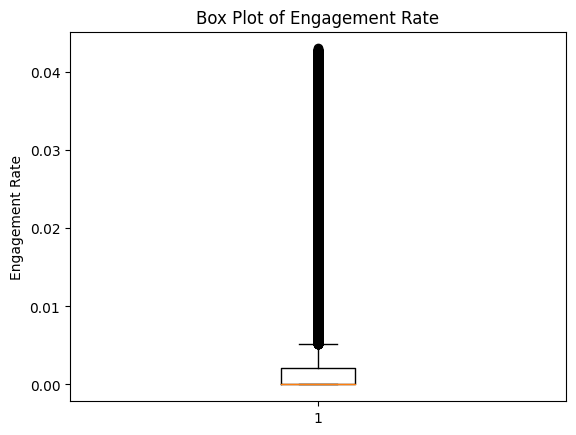

In [ ]:
plt.boxplot(df['engagement_rate'])
plt.ylabel('Engagement Rate')
plt.title('Box Plot of Engagement Rate')
plt.show()

## Remove engagement rate = 0

In [ ]:
df = df[df['engagement_rate']>0]
df.shape

(8365, 9)

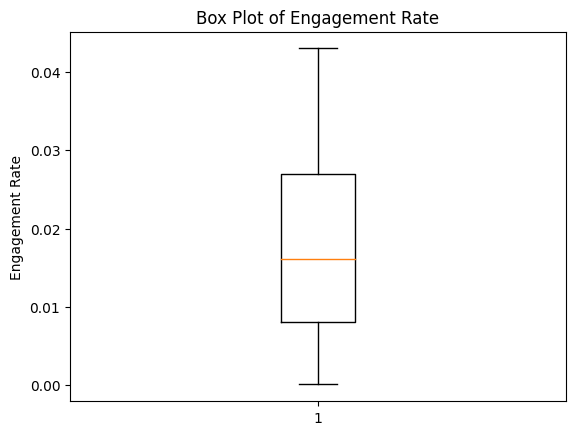

In [ ]:
plt.boxplot(df['engagement_rate'])
plt.ylabel('Engagement Rate')
plt.title('Box Plot of Engagement Rate')
plt.show()

## Keep only English

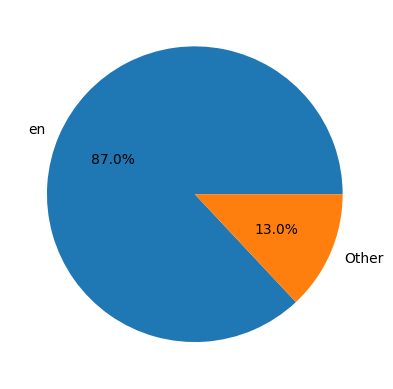

In [ ]:
count_lang(data=df)

In [ ]:
df['language_category'].value_counts()

language_category
en       7276
Other    1089
Name: count, dtype: int64

In [ ]:
df = df[df["language"] == "en"]
df.shape

(7276, 9)

## Keep only Tweets

In [ ]:
# Remove retweets and replies from dataset
# Define regex that identifies retweets and replies
retweet_pattern = r'^RT @\w+:'
reply_pattern = r'^@\w+'
# Create function to classify content
def classify_content(text):
    if re.match(retweet_pattern, text):
        return 'retweet'
    elif re.match(reply_pattern, text):
        return 'reply'
    else:
        return 'tweet'
# Create column content_category
df['content_category'] = df['content'].apply(classify_content)

# Filter dataframe with only tweets
df = df[df['content_category'] == 'tweet'].copy()
df.shape

(4286, 10)

# Preprocess text

Now that our data is clear of outliers and unnecessary data points, we will continue with preprocessing the tweet content.

## Remove hashtags, mentions, emojis and numbers with tweet preprocessor

In [ ]:
# Form a separate feature for cleaned tweets
df["clean"] = [p.clean(text) for text in df["content"]]

## Remove punctuations, tabs and convert to lowercase

In [ ]:
# Extract the cleaned tweets to further preprocessing
data = df["clean"]

Before further cleaning, we will expand the contractions first, e.g don't -> do not

In [ ]:
# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Apply the function to the `data_clean` column
data = data.apply(expand_contractions)

# Print the updated column
print(data)

3259     Ukraine in power is donating food to a country...
3276     So Paul Mashatile is paying alot of money to g...
3303                       Sushi Temple (.com) Click below
3311     The plant metabolic engineers growing proteins...
3322     my mom likes brown so much. I remember when sh...
                               ...                        
37191    the first time skz had cafe food they did not ...
37198                                        lil food dump
37199    My phleb instructor offered to doordash me foo...
37203    everytime my disability makes me way too tired...
37207    Mexican food should not be trusted if made in ...
Name: clean, Length: 4286, dtype: object


In [ ]:
# Remove punctuation
data = [strip_punctuation(sent) for sent in data]

# Remove whitespaces
data = [strip_multiple_whitespaces(sent) for sent in data]

# Remove the word "amp" from the text
data = [sent.replace('amp', '') for sent in data]

# Transform to lowercase
data = [str.lower(sent) for sent in data]

for index,text in enumerate(data[0:10]):
  print('Tweet %d:\n'%(index+1),text)


Tweet 1:
 ukraine in power is donating food to a country where kshs is used daily by on tea and biscuits 
Tweet 2:
 so paul mashatile is paying alot of money to get food parcels some gals are definitely lucky imagine being a millionaire soon she can be a billionaire if she save that money half a million every month you just give the man ziki ziki
Tweet 3:
 sushi temple com click below
Tweet 4:
 the plant metabolic engineers growing proteins from potatoesmaya sapir mir and raya liberman aloni are on a mission to turn of the world s largest food crops into a scalable protein source with molecular farmingtoday they announce 1 75m fundraise to help achieve this
Tweet 5:
 my mom likes brown so much i remember when she told me when i was little i think i started like brown because of her her favorite food is rice and she enjoys teaching
Tweet 6:
 just saw a right to food hunger march leaflet left at a caf that charges for a focaccia 
Tweet 7:
 could be wrong but i think wrote an article on n

## Remove stop words and short words

In [ ]:
# Initialise the stopwords list in nltk
stopwords = stopwords.words("english")

# Additional stop words to remove
additional_stopwords = ['everything','something','someone','must','even','back']

# Add additional stop words to the stopwords list
stopwords.extend(additional_stopwords)

# Remove stopwords
data = [remove_stopwords(text,stopwords=stopwords) for text in data]
print(data[0])

ukraine power donating food country kshs used daily tea biscuits


In [ ]:
# Remove short words
data = [strip_short(text) for text in data]
print(data[0])

ukraine power donating food country kshs used daily tea biscuits


In [ ]:
# Overwrite df["clean"] with data
df["clean"] = data

# Word cloud

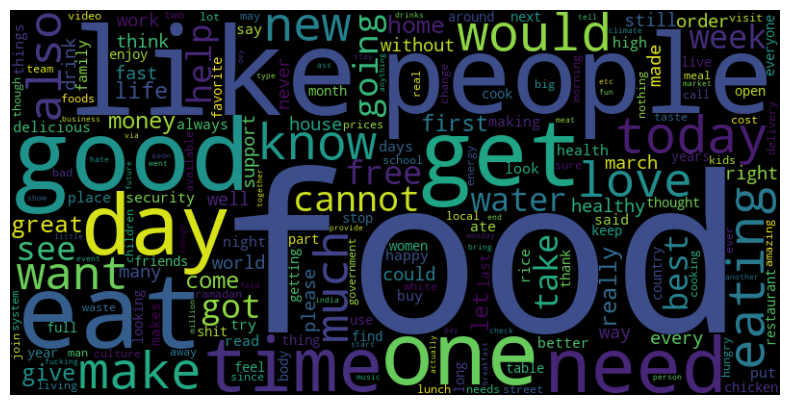

In [ ]:
# Create a string of all tweets
all_tweets = ' '.join(data)

# Split string into individual words
words = all_tweets.split()

# Count the frequency of each word
word_freq = Counter(words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Data storage

In [ ]:
df.to_json('data/training_data_preprocessed.json')
print("File created and saved successfully.")

File created and saved successfully.
